# DC GAN for brain MRI image data

In [1]:
# Importing dependencies

import tensorflow as tf
print(tf.__version__)
import glob
import cv2
from IPython import display


import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array



2.1.0


In [2]:
data_dir = "H://PatternLab//PatternRecognition//Datasets//brain//keras_png_slices_data//keras_png_slices_train//"
images_train = [cv2.imread(file) for file in glob.glob(data_dir + "*.png")]

In [3]:
# importing helper function to handle image data
from image_helper import tf_plot_gallery as plot_gallery


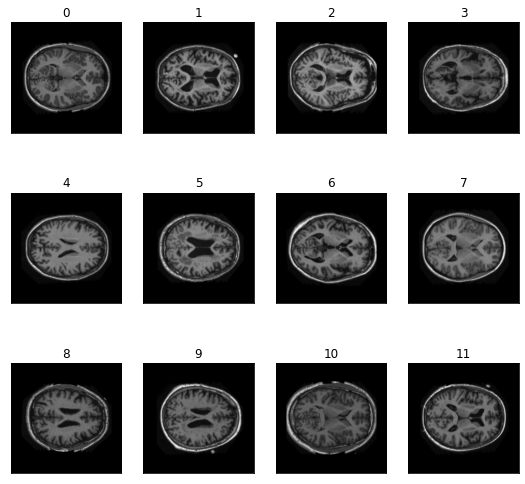

In [4]:
plot_gallery(images_train, images_train[0].shape)

In [5]:
# converting RGB to grayscale
X_train = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images_train]


In [6]:
#resizing images to 128 x 128 
X_train = [cv2.resize(image, (128,128)) for image in X_train]

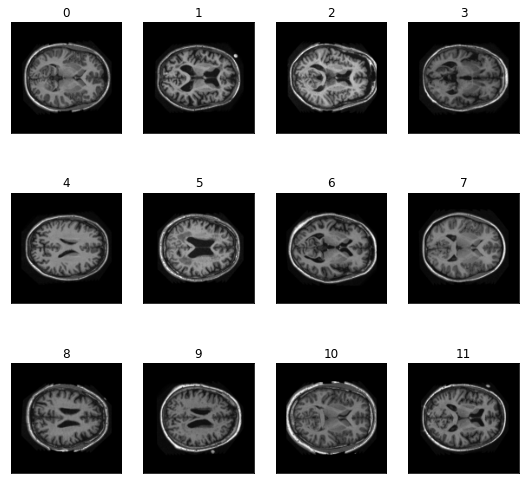

In [7]:
plot_gallery(X_train, (128,128,1))

In [8]:
#converting to tensors
tf_X_train = tf.convert_to_tensor(X_train, dtype = tf.float32)
print(tf_X_train.shape)

tf_X_train =  tf.reshape(tf_X_train, [tf_X_train.shape[0], 128, 128,1])
print('max = ', tf.reduce_max(tf_X_train).numpy())
print('min = ', tf.reduce_min(tf_X_train).numpy())


(9664, 128, 128)
max =  255.0
min =  0.0


In [9]:
#Normalising the dataset 
tf_X_train = (tf_X_train - 127.5)/127.5

In [10]:
print('max = ', tf.reduce_max(tf_X_train).numpy())
print('min = ', tf.reduce_min(tf_X_train).numpy())


max =  1.0
min =  -1.0


In [11]:
#Creating a train batch using tensorflow

In [12]:
BUFFER_SIZE = 8000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(tf_X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 128, 128, 1), types: tf.float32>

In [13]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

## optimizer
#optimizer = Adam(0.0002, 0.5)
optimizer = Adam(0.00007, 0.5)
##optimizer = 'adam'

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

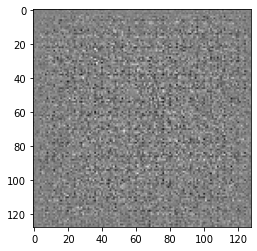

In [14]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)           

In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
# Defnine Training Loop

EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return  (gen_loss, disc_loss)
    

In [23]:
# define Structure similarity function

def get_max_ssim(input_data, test):
    ssim_val = 0
    
    
    for i in range(len(input_data)):
        s = tf.image.ssim(input_data[i], test,1).numpy()
        if (s > ssim_val):
            ssim_val = s
        #if ssim_val > 0.6:
        #    break
    return ssim_val

In [24]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    gen_images_dir = './gen_images'
    gen_images_prefix = os.path.join(gen_images_dir, "image_at_epoch_")

    if(epoch % 5 ==0):
        plt.savefig(gen_images_prefix + '{:04d}.png'.format(epoch))
    plt.show()

In [25]:
ssims = []
gen_losses = []
disc_losses = []
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      (gen_loss, disc_loss) =  train_step(image_batch)

    # Produce images for the GIF as we go
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    
    gen_losses.append(gen_loss.numpy())
    disc_losses.append(disc_loss.numpy())
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    
    test_img = tf.image.convert_image_dtype(generator.predict(np.asarray(seed).reshape(16,100))[0], tf.float32, saturate=False, name=None)
    ssim = get_max_ssim(tf_X_train[:500],test_img)
    ssims.append(ssim)                    
    print('ssim = ', ssim)
    


  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

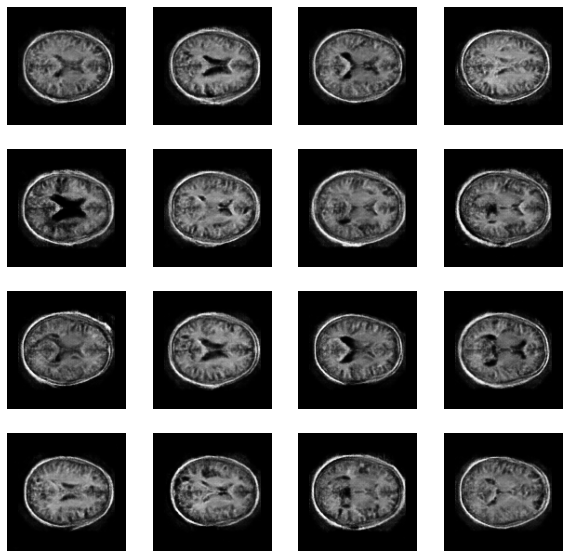

Time for epoch 448 is 10.52189040184021 sec
ssim =  0.6575924


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
disc_losses
gen_losses
ssims